In [3]:
# Importing (using/include) packages and files needed for the code to run
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics
using Dates
using SpecialFunctions
using Roots
using NLsolve
using Printf
using HDF5
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("GridOperations.jl")
include("Topo.jl")
# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Stefan Problem - test melting and solidification

Step 1 - import packages

Step 2 - Define a function that relates entropy and temperature/pressure. 
$$
T = f_1(P,S)
$$

$$
T = \exp \left( \frac{S}{C_V} + \ln (T_{ref}) - \frac{\Delta H_{fus} }{C_V T_M}X \right)
$$

and 
$$
S = f_2(P,T)
$$
$$
S = C_V (\ln (T) - \ln(T_{ref})) + \frac{\Delta H_{fus}}{T_m}X
$$

In [4]:
# functions that relates entropy and temperature/pressure are define in TemperatureEntropy.jl file
include("TemperatureEntropy.jl")

subgirdSdiff! (generic function with 1 method)


Step 3 - Write functions to set up the initial condition for the Stefan problem

- Consider a box with width 100 km and height 100 km.
- The box is filled entirely with one material
- Initially, the top 10 km is solid and the bottom 90 km is liquid.
- The sides are insulating
- Density is constant and equal to 1000 kg/m$^3$
- The surface is at T=100K, the bottom is at T=273 K
- The liquid is isothermal with $T=T_m$.
- The solid has initial $T(z)$ given by the Stefan solution (Turcotte and Schubert section 4.18)
$$
\theta = \frac{erf(\eta)}{erf(\lambda_1)}
$$
- Given the initial temperature, compute initial entropy S on the markers.
  

In [5]:
function initial_ice_depth(x::Float64)
    return options["ym"]
end 

struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    function Materials()
        new([0.0],[1e3],[0.0],[2.1e3],[2.2])
    end    
end

function update_marker_prop!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    X = markers.scalarFields["X"]
    S = markers.scalarFields["S"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
    end
end

function update_marker_T_X!(markers::Markers,materials::Materials,options::Dict)
    T = markers.scalarFields["T"]
    X = markers.scalarFields["X"]
    S = markers.scalarFields["S"]    
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[T,i],markers.scalars[X,i] = compute_T_X_from_S((markers.scalars[S,i]),options)
    end
end

function initial_conditions!(markers::Markers,materials::Materials,options::Dict)
    material = markers.integerFields["material"]
    S = markers.scalarFields["S"]
    X = markers.scalarFields["X"]
    T = markers.scalarFields["T"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    kThermal = markers.scalarFields["kThermal"]
    
    # Setting up Stefan conidtion
    lambda1 = get_lambda1(options)
    t = get_t(lambda1,options)
    
    # Note: the melt fraction is defining our layers or ice and water.
    # water - X = 1.0 
    # ice - X = 0.0
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx)
        
        if my > hice # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[alpha,i] = materials.alpha[1]
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]
            markers.scalars[kThermal,i] = materials.kThermal[1]
            markers.scalars[T,i] = 273.0
            markers.scalars[X,i] = 1.0
            markers.scalars[S,i] = compute_S_from_T_X(markers.scalars[X,i],markers.scalars[T,i],options)

        elseif my < hice # icy shell
            markers.integers[material,i] = 1
            markers.scalars[alpha,i] = materials.alpha[1]
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]
            markers.scalars[kThermal,i] = materials.kThermal[1]
            markers.scalars[T,i] = stefan_initial_condition(get_theta(my,t,lambda1),options)
            markers.scalars[X,i] = 0.0
            markers.scalars[S,i] = compute_S_from_T_X(markers.scalars[X,i],markers.scalars[T,i],options)
        end
    end 
    # end loop over markers
    update_marker_prop!(markers,materials)
end

function get_interface(grid::CartesianGrid,mat::Matrix{Float64},contour_value::Float64)
    # Finding interfaces
    interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[i]
                break
            elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + ((grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j]))*(contour_value-mat[i,j])
                break
            end
            i = i+1
        end
    end
    return interface_position
end

get_interface (generic function with 1 method)

# Main part of code
- At each timestep, begin by computing T(S,X) on the markers
- Iteratively solve the temperature equation. Start with a guess S_new = S_old
    - For T_new, compute $q_{cond} = \nabla \cdot (k \nabla T_{new})$
    - Solve diffusion equation for S_new
    - Given S_new, update T_new
    - Iterate until converged...
- Given the new entropy solution on the cell centers, update the entropy and melt fraction on the markers.

  0.064701 seconds (1.84 M allocations: 28.239 MiB)
1003.3460340963348


sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


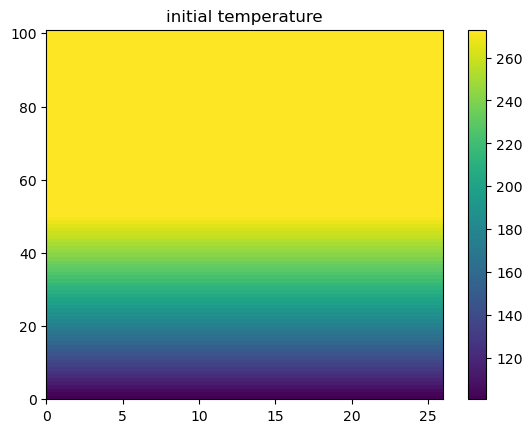

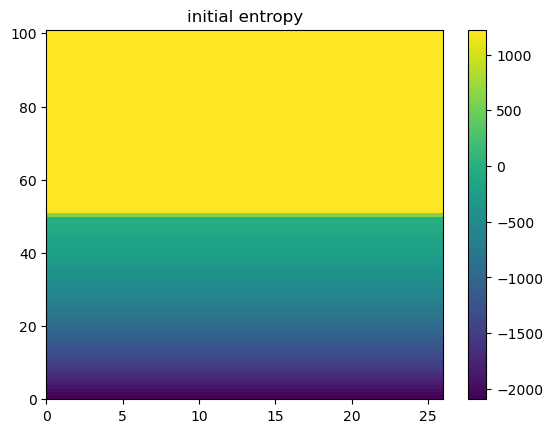

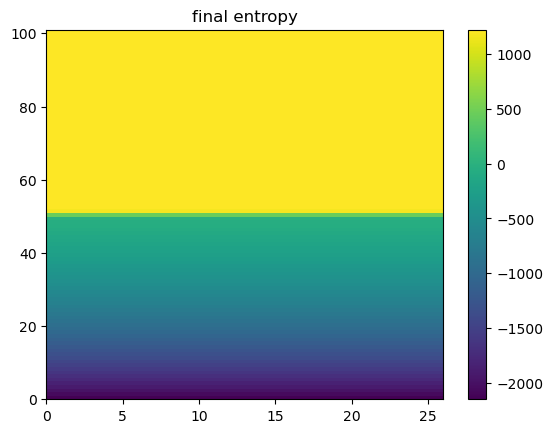

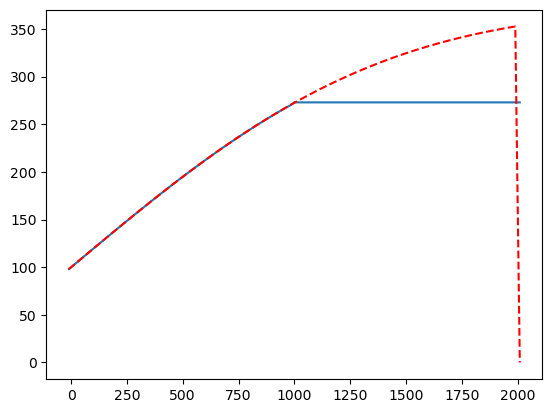

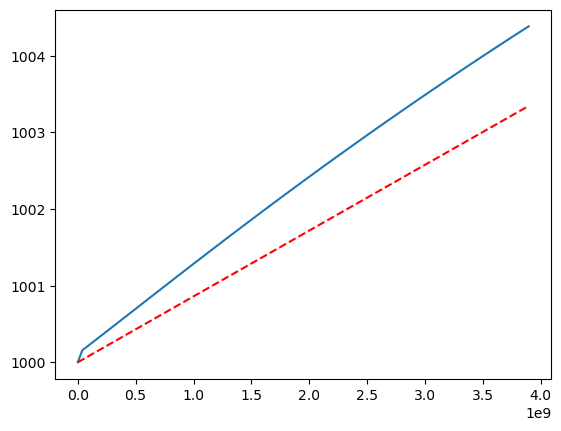

In [23]:
# setup the domain
options = Dict()
options["latent heat of fusion"] = 3.34e5 #J/kg
options["specific heat of ice"] = 2.1e3 # J/kg*K (ice)
options["density of ice"] = 1e3 # kg/m^3
options["thermal conductivity of ice"] = 2.2 # W/m*K
options["thermal diffusivity"] = options["thermal conductivity of ice"] / (options["density of ice"]*options["specific heat of ice"]) # m^2/s

options["Tm"] = 273.0 # K
options["To"] = 100.0 # K
options["ym"] = 1e3 # m 

W = 5e2
H = 2e3
ny = 100
nx = Int64(ceil(W/H*ny))
gx = 0.0
gy = 0.113
markx = 6
marky = 6
seconds_in_year = 3.15e7

materials = Materials()
mygrid = CartesianGrid(W,H,nx,ny)
markers = Markers(mygrid,["alpha","T","rho","Cp","Hr","kThermal","S","X"],["material"] ; nmx=markx,nmy=marky,random=false)
@time initial_conditions!(markers,materials,options)

Tbctype = [-1,-1,1,1] #left, right, top, bottom
Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom

# set up the initial temperature
# Tlast = zeros(ny+1,nx+1)
# Slast = zeros(ny+1,nx+1)
# Xlast = zeros(ny+1,nx+1)
# kThermal_vx = options["thermal conductivity of ice"] .* ones(ny+1,nx+1)
# kThermal_vy = options["thermal conductivity of ice"] .* ones(ny+1,nx+1)
# rho_c = options["density of ice"] .* ones(ny+1,nx+1)
# Hr = zeros(ny+1,nx+1)

lambda1 = get_lambda1(options)
ttmp = get_t(lambda1,options)
# for j=1:nx+1
#     for i=1:ny+1
#         if mygrid.yc[i] > options["ym"]
#             Tlast[i,j] = options["Tm"]
#             Xlast[i,j] = 1.0
#         else
#             Tlast[i,j] = stefan_initial_condition(get_theta(mygrid.yc[i],ttmp,lambda1),options)
#             Xlast[i,j] = 0.0
#         end
#         Slast[i,j] = compute_S_from_T_X(Xlast[i,j],Tlast[i,j],options)
#     end
# end

rho_c,Hr,kThermal,Slast,Xlast, = marker_to_stag(markers,mygrid,["rho","Hr","kThermal","S","X"],"center")
rhocp = markers.scalars[markers.scalarFields["rho"],:] .* markers.scalars[markers.scalarFields["Cp"],:]
Tlast, = marker_to_stag(markers,mygrid,["T"],"center")
kThermal_vx, = marker_to_stag(markers,mygrid,["kThermal",],"vx")
kThermal_vy, = marker_to_stag(markers,mygrid,["kThermal",],"vy")


figure()
pcolor(Tlast)
title("initial temperature")
colorbar()
show()
figure()
pcolor(Slast)
colorbar()
title("initial entropy")
show()
S0 = copy(Slast)

time = 0.0
dt = calculate_diffusion_timestep(mygrid,options)

ocean_ice_interface = []
append!(ocean_ice_interface,options["ym"])
plot_time = []
append!(plot_time,0.0)

for itime in 1:100
    Slast,Xlast,Tlast = marker_to_stag(markers,mygrid,["S","X","T"],"center")
    Snew = copy(Slast)
    Tnew = copy(Tlast)
    Xnew = copy(Xlast)
    for titer in 1:100
        q_vx,q_vy = compute_q_cond(mygrid,Tnew,kThermal_vx,kThermal_vy) # W/m^2
        #dS = compute_S_new(mygrid,Tnew,rho_c,Hr,q_vx,q_vy,Slast,dt) .- Snew
        Snew = compute_S_new(mygrid,Tnew,rho_c,Hr,q_vx,q_vy,Slast,dt)
        Tnew,Xnew = update_T_X_from_S(Snew,options)             
        Tnew,Xnew,Snew = ghost_nodes_center_TXS(mygrid,Tnew,Xnew,Snew,Tbctype,Tbcval,options)
        residual = compute_entropy_residual(mygrid,Tnew,rho_c,Hr,q_vx,q_vy,Slast,Snew,dt)
        Snorm = norm( residual[2:ny,2:nx] )
        #println(titer,":",Snorm)
        if Snorm < 1e-6
            break
        end
    end
    
    dS = Snew - Slast
    cell_center_change_to_markers!(markers,mygrid,dS,"S")
    update_marker_T_X!(markers,materials,options)

    
    interface = get_interface(mygrid,-Snew,-611.0)
    append!(ocean_ice_interface,mean(interface))
    
    # advance to next timestep
    Slast = copy(Snew)
    Xlast = copy(Xnew)
    Tlast = copy(Tnew)
    time += dt
    append!(plot_time,time)
end

figure()
pcolor(Slast)
colorbar()
title("final entropy")
show()


figure()
plot(mygrid.yc,Tlast[:,2])

final_time = ttmp + time
stefan_solution = zeros(ny+1,1)
for j in 1:mygrid.ny
    stefan_solution[j] = stefan_initial_condition( get_theta(mygrid.yc[j],final_time,lambda1),options)
end
plot(mygrid.yc,stefan_solution,"r--")
show()


yfinal = get_y.(lambda1,final_time,Ref(options))
println(yfinal)

figure()
plot(plot_time,ocean_ice_interface)
yfinal = get_y.(lambda1,plot_time .+ ttmp,Ref(options))
plot(plot_time,yfinal,"r--")

show()